# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:

import ibmos2spark
# @hidden_cell
credentials = {
    'endpoint': 'https://s3-api.us-geo.objectstorage.service.networklayer.com',
    'service_id': 'iam-ServiceId-cd73bfae-4dee-4700-9538-9aca46986b8c',
    'iam_service_endpoint': 'https://iam.cloud.ibm.com/oidc/token',
    'api_key': 'VVKSNmWvkEG7znJIm5iKoSytiehv5zEfK6qIOnidR8c6'
}

configuration_name = 'os_0071c2b33ad94ed0b5752143eb58a1c7_configs'
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
# Since JSON data can be semi-structured and contain additional metadata, it is possible that you might face issues with the DataFrame layout.
# Please read the documentation of 'SparkSession.read()' to learn more about the possibilities to adjust the data loading.
# PySpark documentation: http://spark.apache.org/docs/2.0.2/api/python/pyspark.sql.html#pyspark.sql.DataFrameReader.json

df_data_1 = spark.read.json(cos.url('mini_sparkify_event_data.json', 'pyspark-donotdelete-pr-vs1bwxhew57w8l'))
df_data_1.take(5)


Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20201215132750-0000
KERNEL_ID = 6aa6ef35-2bc5-4233-941e-47a86357bb23


[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

In [2]:
# import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import avg, stddev, split, udf, isnull, first, col, format_number, rand
from pyspark.sql.types import IntegerType, FloatType

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression,RandomForestClassifier,DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import re

from pyspark.sql.types import IntegerType, ArrayType, FloatType, DoubleType, Row, DateType, StringType

import time

import datetime
import pyspark.sql.functions as F
%matplotlib inline

In [3]:
# create a Spark session
# spark = SparkSession.builder \
#     .master("local") \
#     .appName("Creating Features") \
#     .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [4]:
# mini_sparktify_event_data = 'mini_sparkify_event_data.json'

# df = spark.read.json(mini_sparktify_event_data)
# df.persist()
# df = df.sample(withReplacement=False, fraction=0.6)

In [5]:
df = df_data_1

In [6]:
df.filter("userId IS NULL").count()

0

In [7]:
df.filter("sessionId IS NULL").count()

0

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [8]:
df.createOrReplaceTempView("Sparkify_local")

In [9]:
df.select("page").distinct().show(20, False)

+-------------------------+
|page                     |
+-------------------------+
|Cancel                   |
|Submit Downgrade         |
|Thumbs Down              |
|Home                     |
|Downgrade                |
|Roll Advert              |
|Logout                   |
|Save Settings            |
|Cancellation Confirmation|
|About                    |
|Submit Registration      |
|Settings                 |
|Login                    |
|Register                 |
|Add to Playlist          |
|Add Friend               |
|NextSong                 |
|Thumbs Up                |
|Help                     |
|Upgrade                  |
+-------------------------+
only showing top 20 rows



#### Define Churn

In [10]:
@udf("integer")
def define_churn_event(page):
    """
    Define Churn base on cancellation page
    """
    if (page == 'Cancellation Confirmation'):
        return 1
    else:
        return 0
udf_define_churn = udf(define_churn_event)

In [11]:
df = df.withColumn('Churn', define_churn_event(df.page))

#### Define Downgrade

In [12]:
userw = Window.partitionBy('userId').rangeBetween(Window.unboundedPreceding,Window.unboundedFollowing)
df = df.withColumn('Downgrade',F.max('Churn').over(userw))

#### Update Temp Table

In [13]:
df.createOrReplaceTempView("Sparkify_local")

In [14]:
df.describe('length').show()

+-------+------------------+
|summary|            length|
+-------+------------------+
|  count|            228108|
|   mean|249.11718197783662|
| stddev| 99.23517921058307|
|    min|           0.78322|
|    max|        3024.66567|
+-------+------------------+



In [15]:
df_len = df.select('length')

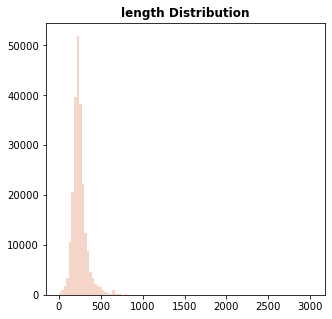

In [16]:
#Distribution plot for length
plt.figure(figsize=(5,5))
sns.distplot(df_len.toPandas().dropna(), bins = 100, kde = False,  color='darksalmon')
plt.title('length Distribution', 
              fontsize=12, fontweight='bold');

In [17]:
spark.sql('''
        SELECT gender, count(DISTINCT userId) AS CNT
        FROM Sparkify_local
        GROUP BY gender
        ORDER BY CNT DESC
''').show(20)

+------+---+
|gender|CNT|
+------+---+
|     M|121|
|     F|104|
|  null|  1|
+------+---+



In [18]:
#notice that we have over 8K records that have null in genders
spark.sql('''
        SELECT Churn, gender, count(sessionId) as cnt_session_id
        FROM Sparkify_local
        GROUP BY Churn, gender
        ORDER BY count(sessionId) DESC
''').show(20)

+-----+------+--------------+
|Churn|gender|cnt_session_id|
+-----+------+--------------+
|    0|     F|        154558|
|    0|     M|        123544|
|    0|  null|          8346|
|    1|     M|            32|
|    1|     F|            20|
+-----+------+--------------+



In [19]:
spark.sql('''
        SELECT Downgrade, sum(length), count(sessionId)
        FROM Sparkify_local
        GROUP BY Downgrade, gender
''').show(20)

+---------+--------------------+----------------+
|Downgrade|         sum(length)|count(sessionId)|
+---------+--------------------+----------------+
|        1|  3822773.0813900004|           19168|
|        0|2.0069595060909994E7|           97880|
|        1|   5225968.883279999|           25696|
|        0|2.7707285121019986E7|          135410|
|        0|                null|            8346|
+---------+--------------------+----------------+



In [20]:
spark.sql('''
        SELECT Downgrade, count(userId)
        FROM Sparkify_local
        GROUP BY Downgrade
''').show(20)

+---------+-------------+
|Downgrade|count(userId)|
+---------+-------------+
|        1|        44864|
|        0|       241636|
+---------+-------------+



In [21]:
df.take(1)

[Row(artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, ts=1539003534000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', Churn=0, Downgrade=0)]

In [22]:
spark.sql('''
        SELECT COUNT(DISTINCT userId ), Churn, level
        FROM Sparkify_local
        GROUP BY Churn, level
''').show()

+----------------------+-----+-----+
|count(DISTINCT userId)|Churn|level|
+----------------------+-----+-----+
|                   196|    0| free|
|                   166|    0| paid|
|                    31|    1| paid|
|                    21|    1| free|
+----------------------+-----+-----+



In [23]:
df_level = spark.sql('''
        SELECT COUNT(DISTINCT userId ) as user_cnt , Downgrade, level
        FROM Sparkify_local
        GROUP BY Downgrade, level
''').toPandas()

In [24]:
df_level

,user_cnt,Downgrade,level
0,150,0,free
1,130,0,paid
2,36,1,paid
3,46,1,free


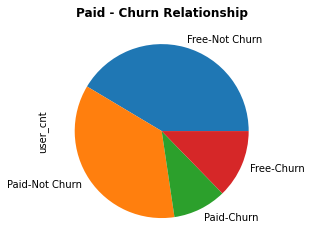

In [25]:
df_level.user_cnt.plot(kind='pie',labels = ['Free-Not Churn', 'Paid-Not Churn','Paid-Churn','Free-Churn']);
plt.title('Paid - Churn Relationship', 
              fontsize=12, fontweight='bold');

#### Status when user churn

In [26]:
df.columns

['artist',
 'auth',
 'firstName',
 'gender',
 'itemInSession',
 'lastName',
 'length',
 'level',
 'location',
 'method',
 'page',
 'registration',
 'sessionId',
 'song',
 'status',
 'ts',
 'userAgent',
 'userId',
 'Churn',
 'Downgrade']

In [27]:
df_at_churn = df.filter(df.Churn == '1').select('level', 'userId').toPandas()

In [28]:
df_at_churn.groupby('level').count().reset_index()

,level,userId
0,free,21
1,paid,31


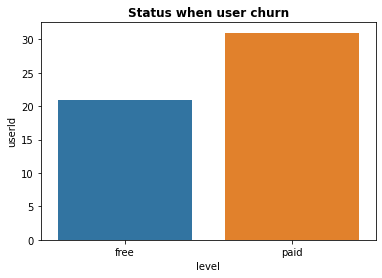

In [29]:
sns.barplot(x = 'level', y = 'userId', data = df_at_churn.groupby('level').count().reset_index())
plt.title('Status when user churn', 
              fontsize=12, fontweight='bold');

#### Churn by Location

In [30]:
spark.sql('''
        SELECT COUNT(DISTINCT userId ) AS CNT, Churn, location
        FROM Sparkify_local
        GROUP BY Churn, location
        ORDER BY CNT DESC
''').show(20, False)

+---+-----+--------------------------------------------+
|CNT|Churn|location                                    |
+---+-----+--------------------------------------------+
|16 |0    |Los Angeles-Long Beach-Anaheim, CA          |
|15 |0    |New York-Newark-Jersey City, NY-NJ-PA       |
|7  |0    |Dallas-Fort Worth-Arlington, TX             |
|7  |0    |Phoenix-Mesa-Scottsdale, AZ                 |
|6  |0    |St. Louis, MO-IL                            |
|6  |0    |Charlotte-Concord-Gastonia, NC-SC           |
|6  |0    |Chicago-Naperville-Elgin, IL-IN-WI          |
|5  |0    |Boston-Cambridge-Newton, MA-NH              |
|5  |0    |Philadelphia-Camden-Wilmington, PA-NJ-DE-MD |
|5  |1    |New York-Newark-Jersey City, NY-NJ-PA       |
|5  |0    |Miami-Fort Lauderdale-West Palm Beach, FL   |
|4  |0    |Houston-The Woodlands-Sugar Land, TX        |
|4  |0    |Washington-Arlington-Alexandria, DC-VA-MD-WV|
|4  |0    |Atlanta-Sandy Springs-Roswell, GA           |
|3  |0    |Las Vegas-Henderson-

In [31]:
df_loc = spark.sql('''
        SELECT COUNT(DISTINCT userId ) AS CNT, Churn, location
        FROM Sparkify_local
        GROUP BY Churn, location
        ORDER BY CNT DESC
''').toPandas()

In [32]:
df_loc.head()

,CNT,Churn,location
0,16,0,"Los Angeles-Long Beach-Anaheim, CA"
1,15,0,"New York-Newark-Jersey City, NY-NJ-PA"
2,7,0,"Phoenix-Mesa-Scottsdale, AZ"
3,7,0,"Dallas-Fort Worth-Arlington, TX"
4,6,0,"St. Louis, MO-IL"


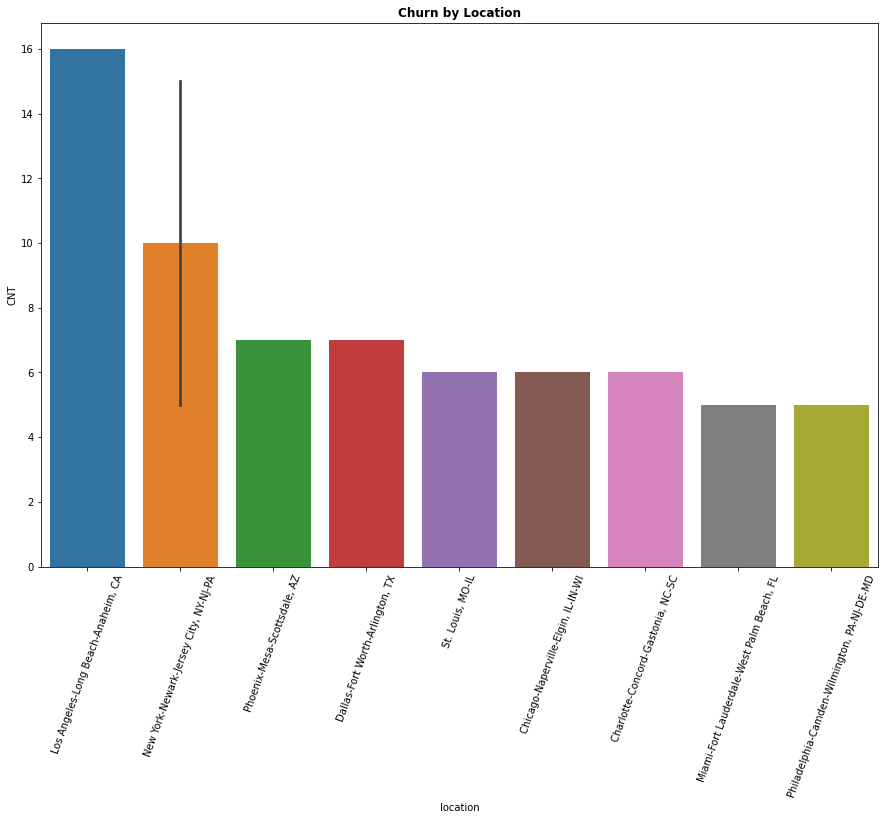

In [33]:
plt.figure(figsize=(15,10))
sns.barplot(x = 'location', y = 'CNT' , data = df_loc.head(10))
plt.xticks(rotation=70)
plt.title('Churn by Location', 
              fontsize=12, fontweight='bold');

In [34]:
df.take(1)

[Row(artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, ts=1539003534000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', Churn=0, Downgrade=0)]

#### Most popular song in the set

In [35]:
df.select('song', 'sessionId').groupby('song').count().sort('count',ascending = False).show()

+--------------------+-----+
|                song|count|
+--------------------+-----+
|                null|58392|
|      You're The One| 1153|
|                Undo| 1026|
|             Revelry|  854|
|       Sehr kosmisch|  728|
|Horn Concerto No....|  641|
|Dog Days Are Over...|  574|
|             Secrets|  466|
|        Use Somebody|  459|
|              Canada|  435|
|             Invalid|  424|
|    Ain't Misbehavin|  409|
|       ReprÃÂ©sente|  393|
|SinceritÃÂ© Et J...|  384|
|Catch You Baby (S...|  373|
|              Yellow|  343|
|    Somebody To Love|  343|
|    Hey_ Soul Sister|  334|
|            The Gift|  327|
|           Fireflies|  312|
+--------------------+-----+
only showing top 20 rows



In [36]:
df_song = df.select('song', 'sessionId').dropna().groupby('song').count().sort('count',ascending = False).toPandas()

/opt/ibm/conda/miniconda/lib/python/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 131 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/ibm/conda/miniconda/lib/python/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 131 missing from current font.
  font.set_text(s, 0, flags=flags)


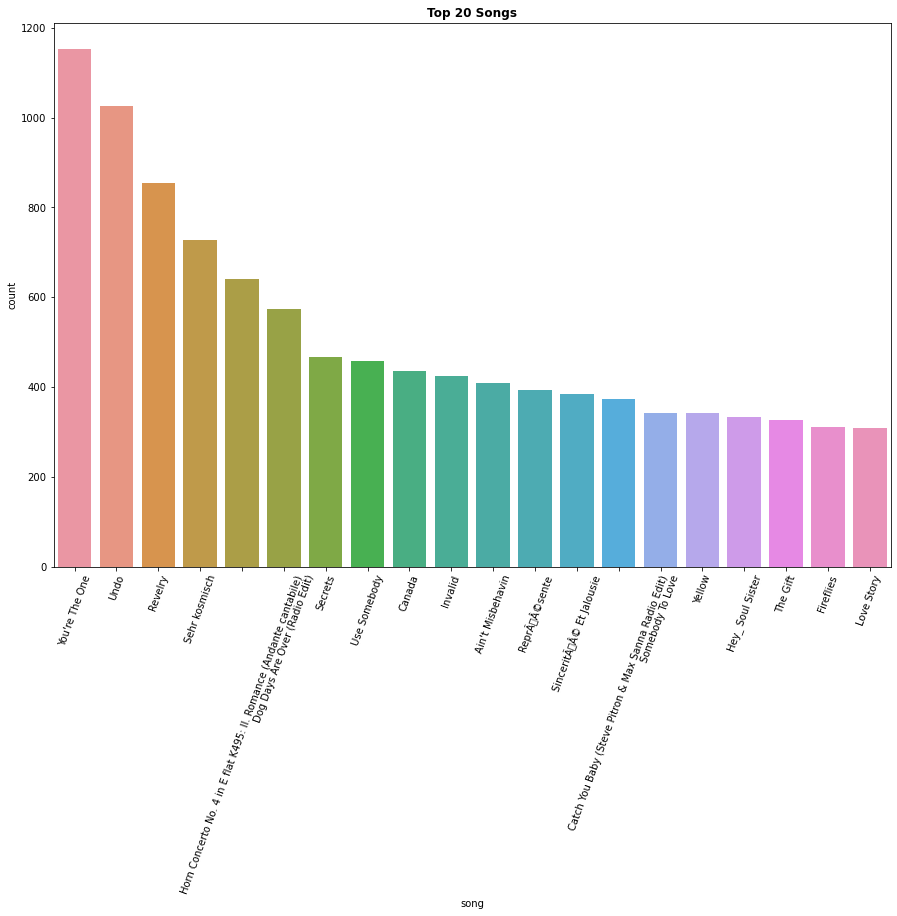

In [37]:
plt.figure(figsize=(15,10))
sns.barplot(x = 'song', y = 'count' , data = df_song.head(20))
plt.xticks(rotation=70)
plt.title('Top 20 Songs', 
              fontsize=12, fontweight='bold');

#### Filter out null user_id

In [38]:
df.select('userId').describe()

DataFrame[summary: string, userId: string]

In [39]:
df = df.filter(df['userId']!='')

In [40]:
df = df.filter(col('auth')!='LoggedOut')

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

#### Get State

In [41]:
df.select('location','userId').withColumn('location', split(col('location'),',').getItem(1)).take(1)

[Row(location=' CA', userId='30')]

In [42]:
def clean_data(df):
    """
    clean data to remove pages with null user_is and logged out users
    """
    df = df.filter(df['userId']!='')
    df = df.filter(col('auth')!='LoggedOut')
    get_hour = udf(lambda x:datetime.datetime.fromtimestamp(x/1000.0). hour)
    df = df.withColumn('hour', get_hour(df.ts))
    df = df.withColumn("hour", df.hour.cast(IntegerType()))
    #udf to convert the ts to timestamp
    get_timestamp = udf(lambda x : datetime.datetime.fromtimestamp(x/ 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
    #apply this udf in the dataframe with your timestamp
    df = df.withColumn("datetime", get_timestamp(df.ts))
    #turn registered hixtime to datetime
    df = df.withColumn("registration_date", get_timestamp(df.registration))
    #create date
    df = df.withColumn('date', F.from_unixtime(col('ts')/1000).cast(DateType()))
    df = df.withColumn('location', split(col('location'),',').getItem(1))
    return df

In [43]:
df = clean_data(df)

In [44]:
df.take(1)

[Row(artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', location=' CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, ts=1539003534000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', Churn=0, Downgrade=0, hour=12, datetime='2018-10-08 12:58:54', registration_date='2018-09-27 02:45:40', date=datetime.date(2018, 10, 8))]

##### Account Age

In [45]:
def account_age(df = df):
    """
    INPUT df
    OUTPUT number of days from the start of registeration
    """
    df_account_age = df.select('ts', 'userId' , 'registration') \
    .withColumn('account_age', df.ts - df.registration) \
    .groupby('userId').agg({'account_age' :'max' }) \
    .withColumnRenamed('max(account_age)', 'account_age') \
    .withColumn('account_age', col('account_age')/1000/3600/24)
    return df_account_age

In [46]:
df_account_age = account_age()

#### Hour of churn

In [47]:
def hr_of_churn(df = df):
    """
    INPUT df
    OUTPUT hour of churn event happended
    """
    # Hour of churn
    hr_of_churn = df.select('hour','userId').filter('Churn == "1"') \
        .groupby(['userId']) \
        .max() \
        .withColumnRenamed('max(hour)', 'hour_of_churn')
    return hr_of_churn

In [48]:
hr_of_churn = hr_of_churn()

#### Get Date

#udf to convert the ts to timestamp
get_timestamp = udf(lambda x : datetime.datetime.fromtimestamp(x/ 1000.0).strftime("%Y-%m-%d %H:%M:%S"))

#apply this udf in the dataframe with your timestamp
df.withColumn("datetime", get_timestamp(df.ts))

#### get total num of songs

In [49]:
def tot_song(df = df):
    """
    INPUT df
    OUTPUT total num of song each user played till date
    """
    # Number of songs listened by each users
    df_tot_song = df.where('page == "NextSong"') \
        .groupby(['userId']) \
        .count() \
        .withColumnRenamed('count', 'tot_songs_played')
    return df_tot_song

In [50]:
df_tot_song = tot_song()

#### total thumbs up and down

In [51]:
spark.sql('''
        SELECT page, count(DISTINCT userId) AS CNT
        FROM Sparkify_local
        GROUP BY page
        ORDER BY CNT DESC
''').show(20)

+--------------------+---+
|                page|CNT|
+--------------------+---+
|            NextSong|225|
|                Home|224|
|           Thumbs Up|220|
|     Add to Playlist|215|
|              Logout|213|
|         Roll Advert|207|
|          Add Friend|206|
|         Thumbs Down|203|
|            Settings|195|
|                Help|193|
|             Upgrade|168|
|               About|156|
|           Downgrade|154|
|       Save Settings|132|
|      Submit Upgrade|131|
|               Error|118|
|Cancellation Conf...| 52|
|              Cancel| 52|
|    Submit Downgrade| 49|
|            Register|  1|
+--------------------+---+
only showing top 20 rows



df_tot_thumbup = df.select('page', 'userId').where('page = "Thumbs Up"').groupby('userId').count().withColumnRenamed('count', 'tot_thumbsup')
df_tot_thumbdown = df.select('page', 'userId').where('page = "Thumbs Down"').groupby('userId').count().withColumnRenamed('count', 'tot_thumbsdown')

#### Create Page Cnt Function

In [52]:
def create_page_cnts(df, page_name):
    """
    Create Function to count different page activities by userid
    """
    df_cnt = df.select('page', 'userId') \
    .where(df.page == page_name) \
    .groupby('userId') \
    .count().withColumnRenamed('count', page_name)
    print(df_cnt.show(5))
    return df_cnt

In [53]:
df_tot_thumbup = create_page_cnts(df, "Thumbs Up")

df_tot_thumbdown = create_page_cnts(df, "Thumbs Down")

+------+---------+
|userId|Thumbs Up|
+------+---------+
|100010|       17|
|200002|       21|
|   124|      171|
|     7|        7|
|    51|      100|
+------+---------+
only showing top 5 rows

None
+------+-----------+
|userId|Thumbs Down|
+------+-----------+
|100010|          5|
|200002|          6|
|   124|         41|
|    51|         21|
|     7|          1|
+------+-----------+
only showing top 5 rows

None


#### add to playlist

In [54]:
df_tot_playlist_song = create_page_cnts(df, "Add to Playlist")

+------+---------------+
|userId|Add to Playlist|
+------+---------------+
|100010|              7|
|200002|              8|
|    51|             52|
|   124|            118|
|     7|              5|
+------+---------------+
only showing top 5 rows

None


#### Add Friend

In [55]:
df_friends = create_page_cnts(df, "Add Friend")

+------+----------+
|userId|Add Friend|
+------+----------+
|100010|         4|
|200002|         4|
|    51|        28|
|   124|        74|
|     7|         1|
+------+----------+
only showing top 5 rows

None


#### Average time

In [56]:
df.take(1)

[Row(artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', location=' CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, ts=1539003534000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', Churn=0, Downgrade=0, hour=12, datetime='2018-10-08 12:58:54', registration_date='2018-09-27 02:45:40', date=datetime.date(2018, 10, 8))]

In [57]:
def avg_time_per_page(df=df):
    """
    input: df
    output: average music played time/length per user
    """
    df_avg_time = df.where('page == "NextSong"') \
    .select('length', 'userId') \
    .groupby('userId') \
    .avg().withColumnRenamed('avg(length)', 'length')
    return df_avg_time

In [58]:
df_avg_time_pp = avg_time_per_page()

In [59]:
df_avg_time_pp.show(5)

+------+------------------+
|userId|            length|
+------+------------------+
|100010|  243.421444909091|
|200002|242.91699209302305|
|   125|261.13913750000006|
|   124|248.17653659965657|
|     7| 253.5605806666668|
+------+------------------+
only showing top 5 rows



#### Average Daily Time

In [60]:
df.take(1)

[Row(artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', location=' CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, ts=1539003534000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', Churn=0, Downgrade=0, hour=12, datetime='2018-10-08 12:58:54', registration_date='2018-09-27 02:45:40', date=datetime.date(2018, 10, 8))]

In [61]:
def avg_daily_active_hour(df = df):
    """
    input: df
    output: average daily active hours per user_id
    """
    df_avg_daily_len = df.select('length', 'userId','date') \
    .groupby('date', 'userId') \
    .sum('length') \
    .withColumnRenamed('sum(length)', 'tot_daily_len') \
    .groupby('userId') \
    .avg('tot_daily_len') \
    .withColumnRenamed('avg(tot_daily_len)', 'avg_daily_len')
    return df_avg_daily_len

In [62]:
df_avg_daily_len = avg_daily_active_hour()

#### Join All Features

In [63]:
def agg_data():
    """
    Joining all data to get the modeling dataframe
    
    """
    joined_df = df_account_age.join(df_avg_time_pp, on='userId', how ='left') \
    .join(df_friends, on='userId', how ='left') \
    .join(df_tot_playlist_song, on='userId', how ='left') \
    .join(df_tot_thumbdown, on='userId', how ='left') \
    .join(df_tot_thumbup, on='userId', how ='left') \
    .join(df_tot_song, on='userId', how ='left') \
    .join(hr_of_churn, on='userId', how ='left') \
    .join(df_avg_daily_len, on='userId', how ='left')
    
    joined_df = joined_df.fillna(0)

    df_cat_feature = df.select('gender', 'location', 'Downgrade', 'userId', 'Churn').drop_duplicates()

    all_df= joined_df.join(df_cat_feature,on='userId')
    all_df = all_df.drop('userId')
    return all_df 

In [64]:
all_df = agg_data()

In [65]:
ls_col = [
 'account_age',
 'length',
 'Add Friend',
 'Add to Playlist',
 'Thumbs Down',
 'Thumbs Up',
 'tot_songs_played',
 'hour_of_churn',
 'avg_daily_len',
 'gender_index',
#  'location_index'
]
# ls_col.append('gender_index')
# ls_col.append('location_index')

In [66]:
def processing_data_pipeline():
    """
    Create data transformation pipline for categorical varaibles
    """
    indexer_gender = StringIndexer(inputCol='gender', outputCol='gender_index')
    indexer_location = StringIndexer(inputCol='location', outputCol='location_index')
    assembler = VectorAssembler(inputCols=ls_col, outputCol='features')
    data_pipeline = Pipeline(stages=[indexer_gender, assembler])
    return data_pipeline

In [67]:
data_pipeline = processing_data_pipeline()

#### Fit the data and split into train & test

In [68]:
model_df = data_pipeline.fit(all_df).transform(all_df)

final_df = model_df.select(model_df.Churn.alias('label'), 'features')

train, test = final_df.randomSplit([0.7, 0.3])

In [69]:
model_df.take(1)

[Row(account_age=55.6436574074074, length=243.421444909091, Add Friend=4, Add to Playlist=7, Thumbs Down=5, Thumbs Up=17, tot_songs_played=275, hour_of_churn=0, avg_daily_len=9562.985335714284, gender='F', location=' CT', Downgrade=0, Churn=0, gender_index=1.0, features=DenseVector([55.6437, 243.4214, 4.0, 7.0, 5.0, 17.0, 275.0, 0.0, 9562.9853, 1.0]))]

#### Split into Validation and Train Set

In [70]:
train,validate = train.randomSplit([0.7,0.2])

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [69]:
def fit_classifier(model_name , train = train, test = test):
    """
    Input: model name, training set, testing set
    Output: Classifer, prediction on the testing set
    """
    print('The {} model is training....'.format(model_name))
    if model_name == 'LogisticRegression':
        md = LogisticRegression()
    if model_name == 'RandomForestClassifier':
        md = RandomForestClassifier()
    if model_name == 'DecisionTreeClassifier':
        md = DecisionTreeClassifier()
    clf = md.fit(train)
    test_results = clf.transform(test)
    f1_score_evaluator = MulticlassClassificationEvaluator(metricName='f1')
    f1_score = f1_score_evaluator.evaluate(test_results.select(col('label'), col('prediction')))
    print('The F1 score on the test set is {:.2%}'.format(f1_score))
    return clf,test_results

In [72]:
for model_name in ['LogisticRegression', 'RandomForestClassifier', 'DecisionTreeClassifier']:
    fit_classifier(model_name)


The LogisticRegression model is training....
The F1 score on the test set is 70.57%
The RandomForestClassifier model is training....
The F1 score on the test set is 65.17%
The DecisionTreeClassifier model is training....
The F1 score on the test set is 68.23%



#### Tunning

#### In this section, I have used the grid search to tune the logistic regression model because it has the best baseline performance out of the box.

In [71]:
lr = LogisticRegression()
paramGrid = ParamGridBuilder().\
            addGrid(lr.regParam,[0.01, 0.05]).\
            addGrid(lr.elasticNetParam,[0.1, 0.5]).\
            build()

crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(metricName="f1"),
                          numFolds=3)

In [72]:
print('The LR model is training...')
cvModel_lr = crossval.fit(train)
test_results = cvModel_lr.transform(test)
f1_score_evaluator = MulticlassClassificationEvaluator(metricName='f1')
f1_score = f1_score_evaluator.evaluate(test_results.select(col('label'), col('prediction')))
print('The F1 score on the test set is {:.2%}'.format(f1_score))

The LR model is training...
The F1 score on the test set is 71.71%


#### Validation

In [73]:
validate_result = cvModel_lr.transform(validate)
f1_score_evaluator = MulticlassClassificationEvaluator(metricName='f1')
f1_score = f1_score_evaluator.evaluate(validate_result.select(col('label'), col('prediction')))
print('The F1 score on the validation set is {:.2%}'.format(f1_score))

The F1 score on the validation set is 81.94%


In [75]:
cvModel_lr.save('lr')

In [77]:
best_model = cvModel_lr.bestModel

####  Conclusion &  Improvement
In this notebook, we walkthroughed how to manipulate a large dataset with Spark in python, apply a data engineering pipeline, and find the best machine learning model. 
Untilizing grid search, we are able to improve our model accuracy 10 % F1 score comparing to the base untuned model. 
There are a lot of other great things that we can do in the distributed system and this is just the tip of the iceberg. We can of course add in more features in the grid search and increase the parameter intervals. Also, we can try more popular & advanced boosting models that will iteratively look at the training data to help reinforce the model.